In [102]:
from google.cloud import bigquery
import pandas as pd

In [3]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: raffo-bq-xperiment


In [4]:
query = """
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.deaths` 
where province_state is null and country_region = "United Kingdom" or country_region = "Italy" or country_region = "Germany"
"""

In [13]:
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query
df = query_job.to_dataframe()
df.set_index('country_region', inplace=True)


In [34]:
df.columns
df.drop(columns=['province_state', 'latitude', 'longitude', 'location_geom'], inplace=True)
df.head()

,_1_22_20,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,...,_4_1_20,_4_2_20,_4_3_20,_4_4_20,_4_5_20,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20
country_region,,,,,,,,,,,,,,,,,,,,,
Germany,0,0,0,0,0,0,0,0,0,0,...,920,1107,1275,1444,1584,1810,2016,2349,2607,2767
Italy,0,0,0,0,0,0,0,0,0,0,...,13155,13915,14681,15362,15887,16523,17127,17669,18279,18849
United Kingdom,0,0,0,0,0,0,0,0,0,0,...,2352,2921,3605,4313,4934,5373,6159,7097,7978,8958


In [43]:
col = df.columns[1:]
index = df.index



In [95]:
day_increase = df.apply(lambda line: [ x - y for (x,y) in (zip(line[1:], line))] , axis=1)
increase_df = pd.DataFrame(zip(*[country for country in day_increase])).T
increase_df.set_index(index,inplace=True)
increase_df.columns = col

increase_df

,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,_2_1_20,...,_4_1_20,_4_2_20,_4_3_20,_4_4_20,_4_5_20,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20
country_region,,,,,,,,,,,,,,,,,,,,,
Germany,0,0,0,0,0,0,0,0,0,0,...,145,187,168,169,140,226,206,333,258,160
Italy,0,0,0,0,0,0,0,0,0,0,...,727,760,766,681,525,636,604,542,610,570
United Kingdom,0,0,0,0,0,0,0,0,0,0,...,563,569,684,708,621,439,786,938,881,980


In [97]:
day_rel_increase = df.apply(lambda line: [ (x - y)/y if y > 0 else 0 for (x,y) in (zip(line[1:], line))] , axis=1)
rel_increase_df = pd.DataFrame(zip(*[country for country in day_rel_increase])).T
rel_increase_df.set_index(index,inplace=True)
rel_increase_df.columns = col

rel_increase_df

,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,_2_1_20,...,_4_1_20,_4_2_20,_4_3_20,_4_4_20,_4_5_20,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20
country_region,,,,,,,,,,,,,,,,,,,,,
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.187097,0.203261,0.151762,0.132549,0.096953,0.142677,0.113812,0.165179,0.109834,0.061373
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058497,0.057773,0.055049,0.046386,0.034175,0.040033,0.036555,0.031646,0.034524,0.031183
United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.314701,0.241922,0.234166,0.196394,0.143983,0.088974,0.146287,0.152297,0.124137,0.122838


In [103]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # adjust font and plot size


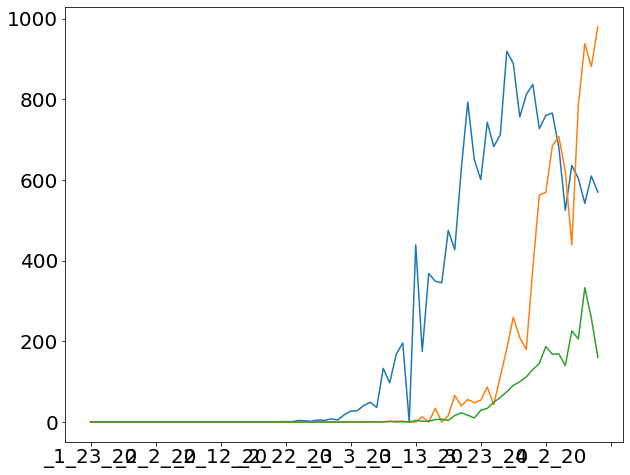

In [113]:
increase_df.loc['Italy'].plot()
increase_df.loc['United Kingdom'].plot()
increase_df.loc['Germany'].plot();
